
---

# CNNによる画像認識

前章で，MNISTを用いた画像の分類問題を説明しました．  
しかし，その際は「28×28の画像を1次元化したもの」を入力として扱っていました．  
直感的に考えると
- 1次元化するよりも，28×28の画像の状態でそのまま入力できた方が上手く学習できそう

な気がします．  

CNN(Convolutional Neural Netwotk)は，そのようなアイデアを形にしたものであり，画像をそのまま入力として扱うことができます．  

今回は，「CIFAR-10」と呼ばれる機械学習用のイメージ学習データを題材にして，CNNによるモデル構築を行います．  
「CIFAR-10データセット」は32×32のカラーイメージが，airplane, automobile, birdなどの10種類のカテゴリに分けられており，イメージカラカテゴリを予測する分類問題の学習データとして用いられており，訓練用に5万枚，検証用に1万枚のデータが公開されています．

MNISTと最大の違いはカラー画像であるという点であり，元データも下図のように
- 画像1枚あたり[3,32,32]という3階テンソル

で表現されます．

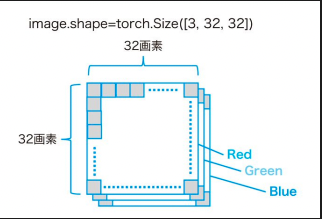

CNNでは「色，縦，横」の3階テンソルの構造を保ったままで画像を処理できます．  
ただし，2層目以降では「色」に該当するインデックスは色ではなくなってしまうため，奥行きにあたるインデックスは一般に「チャンネル」と呼ばれます．


---

## CNNの処理概要
下図に，CNNの元となったAlexNetと呼ばれるネットワーク図を示します．

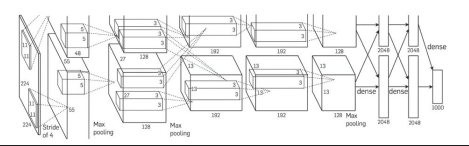

より，一般化した典型的なCNNは下図になります．

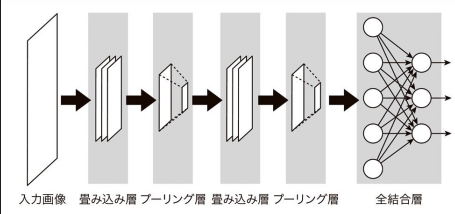

<br>

CNNを特徴づける処理としては「畳み込み処理（Convolution）」と「プーリング処理（Pooling）」があります．  

まず，畳み込み処理について説明します．イメージ図は以下のとおりです．

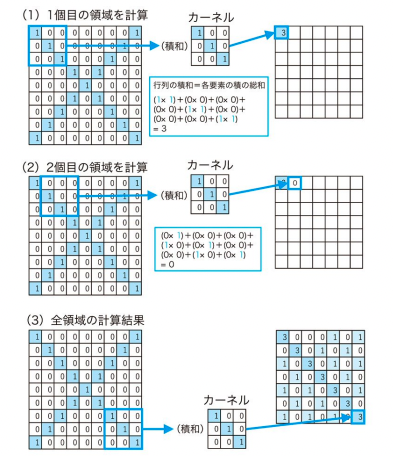

1. まず，3×3や5×5のような小さな正方形領域の配列を用意します．この配列のことを畳み込み処置では「カーネル」と呼びます
    - カーネルのサイズは一般的には奇数です．
2. 次に，元の画像をカーネルと同じ大きさの正方領域で切り取って，カーネルと対応する要素間で積を取り，その結果を加算した結果（積和）を出力領域の出力とします．
3. 切り取る領域を1つずつずらして，同じように積和を取り，隣の領域の出力とします
4. この処理を繰り返すことで，新しい正方形の出力パターンが出来上がります．

実際の畳み込みはもう少し複雑になります．  
入力チャンネルは複数あり，積和演算は全チャンネルにまたがって行われるため「カーネル」もそれに対応して入力チャンネル分あります．  
さらに出力チャンネルも複数あるため，カーネルは全体で4階のテンソルの構造を持つことになります．  

畳み込み処理は，カーネルの内容により，特定の傾きの直線が強調されるなど図形の特徴量の抽出に向いています．  
また，カーネルが移動しながら学習するため位置の移動に無関係な特徴量を検出可能になります．  

下図は，同じ畳み込み処理を何回かかけた結果です．処理を重ねるごとに左下から右上の向きの直線が強調されるようなカーネルが適用されていることが分かります．  

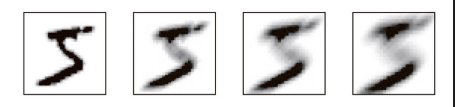


<br>

次に，プーリング処理について説明します．最もよく使用されるMaxPoolingのイメージ図を示します．

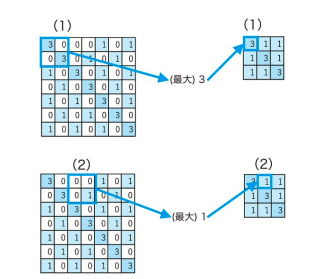

- 2×2などの小さな矩形画像を区切り，その範囲での最大値を出力します．
- 矩形領域をずらして再度最大値を取得し，隣の領域の値とします．

畳み込み処理は，1画素ずつずらして処理することが多いのに対して，プーリング処理は重なる領域を取らないようにずらすのが普通です．  

矩形領域のサイズは2×2が多いですが，これは，
- 縦横ともに元の画像の半分の画素数の新しい画像ができる

ためです．  

<br>

プーリング処理では，画像を縮小するのと同じような効果が期待できます．そのため，
- 物体の大きさによらない普遍的な特徴量を抽出するのに向いている

と言われています．


---

## PytorchでのCNNの実装
今回実装するCNNの全体構造を下図に示します．

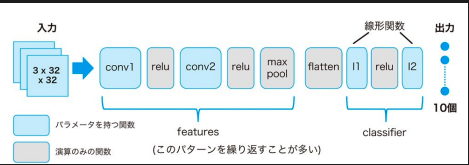

詳細を説明すると
- 畳み込み処理は，PyTorchでは`torch.nn.Conv2d`というレイヤー関数（畳み込み関数）が担っています
    - 上図のconv1, conv2にあたります．
- プーリング処理は`torch.nn.MaxPool2d`というレイヤー関数（プーリング関数）が担っています．
    - 上図のmaxpoolにあたります．
- 上図では，内部にパラメータを持つもの（＝学習対象）と，そうでないものを色分けしています．
    - 畳み込み関数，線形関数：関数の内部にパラメータを持ちます，
    - プーリング関数，ReLU関数：単なる演算なのでパラメータは持ちません．
- 「1階化関数（flatten）」では，チャンネル，縦，横と3階の広がりを持つ「畳み込み関数」「プーリング関数」の出力を横1列の1階テンソルに変換しています．
    - 分類モデルでは，最終的な出力が1階テンソル（今回の場合は，10個のクラス）なので，どこかのタイミングでこの処理が必要になります．
    - Pytrochではview関数を使うことも多いですが，ここでは`torch.nn.Flatten`というレイヤー関数を用いて実装します．

<br>

ここからは，それぞれのレイヤーについて詳しく説明します．  
まずは，`torch.nn.conv2d`と`torch.nn.MaxPool2d`について説明します．  

畳み込み関数`torch.nn.conv2d`は，引数に以下の3つを設定します．
- 第1引数：入力チャンネル数
- 第2引数：出力チャンネル数
- 第3引数：フィルターとなるカーネルの1辺の画素数を意味するカーネルサイズを指定

プーリング関数torch.nn.MaxPool2d`は，引数に以下を設定します．
- 第1引数：小さい矩形の縦と横の画素数

ReLUは単なる関数でパラメータを持たないため，利用時には同じ関数を使い回す前提なので1つしか定義していません．

In [ ]:
import torch
# CNN前半部分 レイヤー関数の定義

conv1 = torch.nn.Conv2d(3, 32, 3)
relu = torch.nn.ReLU(inplace=True)
conv2 = torch.nn.Conv2d(32, 32, 3)
maxpool = torch.nn.MaxPool2d((2,2))

<br>

ここで，conv1とconv2の内部パラメータを確認して見ましょう．  
conv1とconv2のweightは4つのインデックスを持つ4階のテンソルになっています．  
下図のように
- weightのshapeは最初の要素であり「32」は出力チャンネル数に対応しており
- 2つ目の要素の「3」は入力チャンネル数

を表しています．  

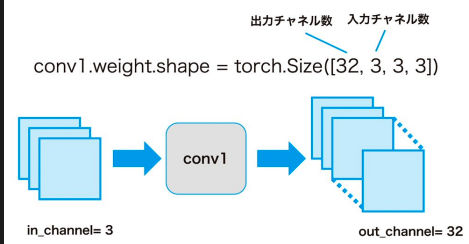

<br>

次に，conv1.weightの内部構造を下図に示します．  
下図では
- 出力チャンネル1用のカーネルは「入力チャンネル0用」から「入力チャンネル2用」まで3枚あります．
- また，実際の畳み込み処理では積和演算を全部で「入力チャンネル数」回（図の場合3回）行うことになります．
- そして，その結果を全て加算したものが最終的に「出力チャンネル1」のパターンとなります．
- 全体では，「出力チャンネル0」から「出力チャンネル31」までの全部で32セット，このようなパラメータが存在することになります．

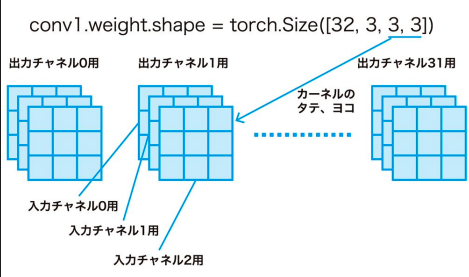

In [ ]:
print(conv1)

# conv1の内部変数のshapeを確認
print(conv1.weight.shape)
print(conv1.bias.shape)

# conv2の内部変数のshapeを確認
print(conv2.weight.shape)
print(conv2.bias.shape)

<br>

ここで，CNNの前半部分の処理をシミュレーションして見ましょう．

In [ ]:
# ダミーで入力と同じサイズのテンソルを生成
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

<br>

CNN途中段階でshapeを確認して見ます．  
この時，`torch.Size(データ件数，チャンネル数，画素数)`の順番になります．  

<br>

畳み込み処理の部分を確認してみると
- 畳み込み関数を1回通るたびに「32->30」「30->28」と2ずつ減っている

ことが分かります．これは，今回畳み込み処理で使用している重み行列（カーネル）のサイズが3×3であることと，畳み込み関数を通すと「畳み込み処理行列のサイズ-1」だけ出力データの画素数が減ることに対応しています．

<br>

次に，プーリング処理の部分を確認してみると
- 縦と横のサイズが半分の「14」になっている

ことが分かります．

<br>

最後に，ReLU関数では
- サイズに変化がない

ことが分かります．

In [ ]:
print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

<br>

ここで，先ほどシミュレーションした
```
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)
```

の部分を確認すると，複数の関数の合成関数で構成されており，各関数が一直線に繋がる形になっていることが分かります．  

これと全く同じ処理を`torch.nn.Sequential`を使って実現できます．実際に，動作確認してみると先ほどと同じ動作をすることが確認できるはずです．

In [ ]:
# 関数定義
features = torch.nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

# 動作テスト
outputs = features(inputs)

print(outputs.shape)

<br>

`torch.nn.Flatten`は，1階のテンソルの形に変更する役割を持っており，実際に使用してみると，入力時に[100,32,32,14]だったshapeが[100,6272]の1階テンソル(32×14×14=6272)に変換されていることが分かります．

In [ ]:
# 関数定義
flatten = torch.nn.Flatten()

# 動作テスト
outputs2 = flatten(outputs)

print(outputs.shape)
print(outputs2.shape)


---

## 共通関数の利用

実効な医療が複雑になってくるとコードが長くなってきます．しかし，よく見てみると同じようなパターンの処理が何回も出てきていることが分かります．  

そこで，このようなパターンを5つ抽出して，それぞれを共通関数として定義することにします．  

共通関数にすることで実行結果が変わることはありませんが
- 人が見やすいコードを書く

ことができます．　

- eval_loss(損失関数)
  - 最初にデータローダーを使って，入力データと正解データを取得します
  - 入力データとモデルインスタンスから予測値を計算します
  - 予測値と正解データを使って損失を計算します

In [ ]:
# 損失計算用
def eval_loss(loader, device, net, criterion):

  # データローダーから最初の1セットを取得
  for images, labels in loader:
    break
  
  # デバイスの割り当て
  inputs = images.to(device)
  labels = labels.to(device)

  # 予測計算
  outputs = net(inputs)

  # 損失計算
  loss = criterion(outputs, labels)

  return loss

<br>

- fit(学習)
  - 今まで「繰り返し計算」と呼んでいた箇所を関数呼び出しで行います
  - 引数
    - net：学習対象のモデルインスタンス
    - optimizer：最適化関数のインスタンス
    - num_epochs：繰り返し数
    - train_loader：訓練用のデータローダー
    - test_loader：検証用のデータローダー
    - device：GPU or CPU
    - history：これまでのhistory
  - 戻り値
    - history：7章までのhistoryと同様に（繰り返し回数，訓練損失，訓練精度，検証損失，損失精度）の2次元配列をNumPy形式で返します  
  <br>  
  - 前章までと比較した追加部分
    - 引数もhistoryとして指定している
      - ディープラーニングではnum_epochsの設定が難しく，少ないと，学習不足になる可能性があり，多すぎると過学習が発生する可能性がある．
      - そこで，fit関数では引数historyに今までのhistoryを渡します．すると，「追加学習」の扱いで過去分も追加したhistoryを生成してくれます（以下，該当部分）  

      ```
      def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

          base_epochs = len(history)
        
          for epoch in range(base_epochs, num_epochs+base_epochs):
              train_loss = 0
              train_acc = 0
      ```  

    - net.train(), net.eval()
      - それぞれ，訓練フェーズ，予測フェーズの先頭で呼び出します
      - この2つの関数はモデルクラスを定義する際に利用している親クラスnn.Moduleで定義されています


In [ ]:
import numpy as np
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ-----------------------------------------------------
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ ----------------------------------------------------
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

<br>

- evaluate_history(学習ログ)
  - 学習結果の評価に関して
    - historyの先頭と最後をprint関数で表示して学習結果の概要を表示
    - 学習曲線を損失，精度の2つで表示  

    というパターンを一つの関数にまとめました．

In [ ]:
!pip install japanize_matplotlib | tail -n 1

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

<br>  

- show_images_labels(予測結果表示)
  - 事前学習済みモデルで正しい予測ができているかを，元データのイメージ表示とともに行います
  - また，モデルを作る前に，イメージと正解データ（ラベル）だけを表示することも可能です
  - 対象は，データローダーで取得される先頭50件（ローダーで定義される件数が50件以下の場合はその件数）になります
  - 引数
    - loader：検証用データローダー
    - classes：正解データに対応するラベル値のリスト．本章の場合，正解データに対応するラベル値である「plane」「car」「bird」などを含んだリストです
    - net：予測対象の事前学習済みモデルインスタンス． Noneを渡すと正解データのみを表示でき，学習前にデータの様子を確認したい時に使用します
    - device：予測計算に利用するデバイス．予測結果も表示するときにのみ利用します
  - 以下が，条件によりタイトル表示を可変にする本質的な部分になります  
  ```
  if net is not None:
    predicted_name = classes[predicted[i]]
    # 正解かどうかで色分けをする
    if label_name == predicted_name:
      c = 'k'
    else:
      c = 'b'
    ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
  else: # netがNoneの場合は、正解ラベルのみ表示
    ax.set_title(label_name, fontsize=20)
  ```  
  - 「正解値：予測値」の形式でテキストを表示しますが，予測値が正解値と異なっている場合だけ，タイトルの色が青になるようにしてあります．  
  - netがNoneの場合は，正解値のみをタイトルに表示します  
  - また，前章と異なりイメージの画像データが「3,32,32]の3階テンソル形式になっている．このため，実際にイメージを表示するための手順がやや煩雑となります

In [ ]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

<br>  

- torch_seed(乱数初期化)
  - 乱数を初期化して，いつも同じ結果になるための処理です
  - GPUを使って計算した場合，乱数の種を固定しただけでは結果が同一にならないことがあるので，その現象が起きないように2行追加しています

In [ ]:
# PyTorch乱数固定用

def torch_seed(seed=123):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.use_deterministic_algorithms = True


---

## データ準備

最初にTransformsを定義します．  
今回は，比較ように前章の「全結合型ニューラルネットワーク」の学習も行うため，1階テンソル版と3階テンソル版の2種類を用意します．

In [ ]:
import torchvision.transforms as transforms

# Transformsの定義

# transform1 1階テンソル
transform1  = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5),
  transforms.Lambda(lambda x: x.view(-1)),                                
])

# transform2 正規化のみ実施

# 検証用データ：正規化のみ実施
transform2 = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5),
])

<br>
データセットに関しても，同様に2種類用意します．

In [ ]:
import torchvision.datasets as datasets

# データ取得用関数　データセット

data_root = "./data"

# 訓練用データセット　1階テンソル版
train_set1 = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform1
)

# 検証データセット 1階テンソル版
test_set1 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform1)

# 訓練データセット 3階テンソル版
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True, 
    download = True, transform = transform2)

# 検証データセット 3階テンソル版
test_set2 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform2)


# データセットの確認 ----------------
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

<br>

データローダーも同様に2種類用意します．

In [ ]:
from torch.utils.data import DataLoader
# データローダーの定義

# ミニバッチサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので，シャッフルをかける
train_loader1 =  DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にはシャッフル不要
test_loader1 = DataLoader(test_set1, batch_size=batch_size, shuffle=False)

# 訓練用データローダー
# 訓練用なので，シャッフルをかける
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にはシャッフル不要
test_loader2 = DataLoader(test_set2, batch_size, shuffle=False)

# 検証データのイメージ表示 ----------------
# 正解ラベル定義
classes = ("plane", "car", "bird", "cat",
           "deer", "dog", "frog", "horse", "ship", "truck")

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

## モデル定義（全結合版）
最初に比較用の「全結合版」のモデルを定義します．

In [ ]:
# 入力次元数 今回は3*32*32=3072
n_input = image1.view(-1).shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(set(list(labels1.data.numpy())))

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')


# モデルの定義 ----------------------
# モデルの定義
# 3072入力10出力1隠れ層のニューラルネットワークモデル

class Net(torch.nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = torch.nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = torch.nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = torch.nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3


---

## 結果（全結合版）
結果を確認してみます．なお，共通関数fitを定義しているため，学習の実装コードが1行で済むようになっています．

In [ ]:
import torch.optim as optim

# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数：交差エントロピー関数
criterion = torch.nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数：勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history = np.zeros((0, 5))

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

<br>  

evaluate_history関数で評価を行います．  
結果を見ると，検証データに対するグラフから繰り返し回数30回程度で上限で，精度は53%程度になっていることが分かります．

In [ ]:
# 評価
evaluate_history(history)


---

## モデル定義（CNN版）
今回のforward関数は，`features`,`flatten`,`classifier`の3つの呼び出しを組み合わせた形になっています．  
`features`と`classifier`は`torch.nn.Sequential`で作成されており，それぞれ
- `features`：畳み込み関数とプーリング関数から構成
- `classifier`：線形関数から構成されている分類器

といった構成になっています．  
そして，`flatten`は上記の2つをつなげる橋渡し役を担っています．


In [ ]:
class CNN(torch.nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(3, 32, 3)
    self.conv2 = torch.nn.Conv2d(32, 32, 3)
    self.relu = torch.nn.ReLU(inplace=True)
    self.maxpool = torch.nn.MaxPool2d((2,2))
    self.flatten = torch.nn.Flatten()
    self.l1 = torch.nn.Linear(6272, n_hidden)
    self.l2 = torch.nn.Linear(n_hidden, n_output)

    self.features = torch.nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = torch.nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3 

# モデルインスタンス生成 -------------------
net = CNN(n_output, n_hidden).to(device)


# 損失関数，最適化関数の定義 --------------------
# 損失関数： 交差エントロピー関数
criterion = torch.nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)    


---

## 結果（CNN版）
CNNで学習を行います．

In [ ]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

<br>

結果を確認すると，精度が66%程度でていることが分かります．全結合の時は53%だったので精度が向上していることが確認できました．


In [ ]:
evaluate_history(history2)

# show_images_labelsで予測結果付きで表示
show_images_labels(test_loader2, classes, net, device)